# Network Security Capstone - Data Overview

**Purpose:** Load and explore both BETH and UNSW-NB15 datasets to understand their structure, characteristics, and suitability for anomaly detection and classification tasks.

---

## Datasets:
- **BETH Dataset**: Honeypot system call logs for unsupervised anomaly detection
- **UNSW-NB15 Dataset**: Network traffic data for supervised attack classification

---

**Author:** Joshua Laubach  
**Date:** October 27, 2025

## Table of Contents

1. [Import Required Libraries](#1-import-required-libraries)
   - 1.1 Memory Monitoring Setup
2. [Load Datasets](#2-load-datasets)
3. [BETH Dataset Overview](#3-beth-dataset-overview)
   - 3.1 BETH Feature Distributions
   - 3.2 BETH Data Quality Checks
4. [UNSW-NB15 Dataset Overview](#4-unsw-nb15-dataset-overview)
   - 4.1 UNSW-NB15 Feature Distributions
   - 4.2 UNSW-NB15 Outlier Detection
5. [Dataset Summary](#5-dataset-summary)
   - 5.1 Key Findings from Exploratory Analysis
   - 5.2 Next Steps - Modeling Pipeline
6. [Feature Engineering Preview](#6-feature-engineering-preview)
7. [Export Summary Statistics](#7-export-summary-statistics)

---

## 1. Import Required Libraries

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Add src directory to path
import sys
from pathlib import Path
src_path = str(Path('../src').resolve())
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import custom modules
from preprocessing import prepare_datasets
from utils import set_seed

# Set random seed for reproducibility
set_seed(42)

print("[SUCCESS] All libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

[INFO] Random seed set to 42
[SUCCESS] All libraries imported successfully!
NumPy version: 2.3.1
Pandas version: 2.3.1


### 1.1 Memory Monitoring Setup

Track memory usage throughout the notebook to ensure efficient resource utilization.

In [2]:
import psutil
import os

def get_memory_usage():
    """Get current memory usage in MB."""
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / 1024 / 1024  # Convert to MB

def print_memory_status(label=""):
    """Print current memory usage with optional label."""
    mem_mb = get_memory_usage()
    available = psutil.virtual_memory().available / 1024 / 1024
    total = psutil.virtual_memory().total / 1024 / 1024
    percent = psutil.virtual_memory().percent
    
    print(f"\n{'='*80}")
    print(f"MEMORY STATUS{' - ' + label if label else ''}")
    print(f"{'='*80}")
    print(f"  Process Memory:     {mem_mb:,.1f} MB")
    print(f"  System Available:   {available:,.1f} MB / {total:,.1f} MB")
    print(f"  System Usage:       {percent:.1f}%")
    print(f"{'='*80}\n")
    
    # Warning if memory usage is high
    if percent > 80:
        print("  WARNING: System memory usage is high (>80%)!")
        print("   Consider closing other applications or restarting the kernel.\n")
    elif percent > 90:
        print(" CRITICAL: System memory usage is critical (>90%)!")
        print("   Risk of out-of-memory errors. Restart kernel immediately.\n")
    
    return mem_mb

# Baseline memory measurement
baseline_memory = print_memory_status("Baseline - Before Data Loading")


MEMORY STATUS - Baseline - Before Data Loading
  Process Memory:     202.1 MB
  System Available:   3,744.7 MB / 16,384.0 MB
  System Usage:       77.1%



## 2. Load Datasets

Load both BETH and UNSW-NB15 datasets using the preprocessing pipeline.

In [ ]:
# Load all datasets using preprocessing pipeline
beth_train, beth_val, beth_test, unsw_train, unsw_val, unsw_test = prepare_datasets()

print("\n" + "="*80)
print("DATASETS LOADED SUCCESSFULLY")
print("="*80)

[INFO] BETH dataset located at /Users/josh/.cache/kagglehub/datasets/katehighnam/beth-dataset/versions/3
[INFO] Original BETH data saved to /Users/josh/Documents/BU/network_security_capstone/data/beth
[INFO] Applying log1p transformations to BETH skewed features...
[INFO] Created 3 log-transformed features:
   - log_timeSinceBoot (original removed)
   - log_processId (original removed)
   - log_parentProcessId (original removed)
[INFO] Applying log1p transformations to BETH skewed features...
[INFO] Created 3 log-transformed features:
   - log_timeSinceBoot (original removed)
   - log_processId (original removed)
   - log_parentProcessId (original removed)
[INFO] Applying log1p transformations to BETH skewed features...
[INFO] Created 3 log-transformed features:
   - log_timeSinceBoot (original removed)
   - log_processId (original removed)
   - log_parentProcessId (original removed)
[INFO] Preprocessed BETH data saved to /Users/josh/Documents/BU/network_security_capstone/data/beth
[IN

In [ ]:
# Check memory after loading datasets
after_load_memory = print_memory_status("After Loading All Datasets")

# Calculate memory used by datasets
datasets_memory = after_load_memory - baseline_memory
print(f" Estimated memory used by datasets: {datasets_memory:,.1f} MB")

# Individual dataset sizes
print(f"\nDataset memory breakdown:")
print(f"  BETH train:  {beth_train.memory_usage(deep=True).sum() / 1024**2:>8.1f} MB  ({len(beth_train):>8,} rows)")
print(f"  BETH val:    {beth_val.memory_usage(deep=True).sum() / 1024**2:>8.1f} MB  ({len(beth_val):>8,} rows)")
print(f"  BETH test:   {beth_test.memory_usage(deep=True).sum() / 1024**2:>8.1f} MB  ({len(beth_test):>8,} rows)")
print(f"  UNSW train:  {unsw_train.memory_usage(deep=True).sum() / 1024**2:>8.1f} MB  ({len(unsw_train):>8,} rows)")
print(f"  UNSW val:    {unsw_val.memory_usage(deep=True).sum() / 1024**2:>8.1f} MB  ({len(unsw_val):>8,} rows)")
print(f"  UNSW test:   {unsw_test.memory_usage(deep=True).sum() / 1024**2:>8.1f} MB  ({len(unsw_test):>8,} rows)")

total_df_memory = (beth_train.memory_usage(deep=True).sum() + 
                   beth_val.memory_usage(deep=True).sum() + 
                   beth_test.memory_usage(deep=True).sum() + 
                   unsw_train.memory_usage(deep=True).sum() + 
                   unsw_val.memory_usage(deep=True).sum() + 
                   unsw_test.memory_usage(deep=True).sum()) / 1024**2

print(f"  {''*50}")
print(f"  TOTAL:       {total_df_memory:>8.1f} MB")

# Memory efficiency check
if datasets_memory > 0:
    overhead = ((datasets_memory - total_df_memory) / datasets_memory) * 100
    print(f"\n Memory overhead (Python objects, indices, etc.): {overhead:.1f}%")


MEMORY STATUS - After Loading All Datasets
  Process Memory:     1,447.8 MB
  System Available:   3,948.8 MB / 16,384.0 MB
  System Usage:       75.9%

 Estimated memory used by datasets: 1,248.0 MB

Dataset memory breakdown:
  BETH train:     241.4 MB  ( 763,144 rows)
  BETH val:        57.5 MB  ( 188,967 rows)
  BETH test:       68.6 MB  ( 188,967 rows)
  UNSW train:      91.3 MB  (  82,332 rows)
  UNSW test:      194.5 MB  ( 175,341 rows)
  
  TOTAL:          653.3 MB

 Memory overhead (Python objects, indices, etc.): 47.7%
  UNSW test:      194.5 MB  ( 175,341 rows)
  
  TOTAL:          653.3 MB

 Memory overhead (Python objects, indices, etc.): 47.7%


## 3. BETH Dataset Overview

**BETH (BSTRACT Event Telemetry for Honeypots)** is a dataset of system call logs from honeypot systems. It contains both normal and malicious activity for **unsupervised anomaly detection**.

### Key Characteristics:
- **Training Set**: Mostly normal activity with minimal labeled anomalies
- **Validation Set**: For tuning anomaly detection thresholds
- **Test Set**: Contains labeled 'sus' (suspicious) and 'evil' (malicious) events
- **'sus'**: In-distribution outliers (subtle anomalies)
- **'evil'**: Out-of-distribution outliers (clear attacks)

In [ ]:
# Display basic statistics for BETH datasets
print("="*80)
print("BETH DATASET - BASIC STATISTICS")
print("="*80)

print("\n[BETH Training Set]")
print(f"   Shape: {beth_train.shape}")
print(f"   Memory Usage: {beth_train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n[BETH Validation Set]")
print(f"   Shape: {beth_val.shape}")
print(f"   Memory Usage: {beth_val.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n[BETH Test Set]")
print(f"   Shape: {beth_test.shape}")
print(f"   Memory Usage: {beth_test.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n" + "="*80)

# Display sample of training data
print("\n[Sample of BETH Training Data]")
print(beth_train.head(10))

# Check for null values
print("\n[BETH Training Set - Null Values]")
null_counts = beth_train.isnull().sum()
if null_counts.sum() > 0:
    print(null_counts[null_counts > 0])
else:
    print("   No null values found!")

# Check for target distribution in test set
if 'sus' in beth_test.columns and 'evil' in beth_test.columns:
    print("\n[BETH Test Set - Target Distribution]")
    normal_count = ((beth_test['sus']==0) & (beth_test['evil']==0)).sum()
    sus_count = (beth_test['sus']==1).sum()
    evil_count = (beth_test['evil']==1).sum()
    total = len(beth_test)
    
    print(f"   Normal (sus=0, evil=0): {normal_count:6d} ({100*normal_count/total:5.2f}%)")
    print(f"   Suspicious (sus=1):     {sus_count:6d} ({100*sus_count/total:5.2f}%)")
    print(f"   Evil (evil=1):          {evil_count:6d} ({100*evil_count/total:5.2f}%)")


BETH DATASET - BASIC STATISTICS

[BETH Training Set]
   Shape: (763144, 17)
   Memory Usage: 241.39 MB

[BETH Validation Set]
   Shape: (188967, 17)
   Memory Usage: 57.47 MB

[BETH Test Set]
   Shape: (188967, 17)
   Memory Usage: 68.57 MB


[Sample of BETH Training Data]
     userId  mountNamespace  hostName   eventId   argsNum  returnValue  \
0  2.611704        1.783991         0 -0.340569  1.736080    -0.054994   
1  2.611704        1.783991         0 -0.740447 -1.246980    -0.054994   
2  2.611704        1.783991         0  1.874340 -1.992744    -0.054994   
3 -0.060910       -0.587102         0 -0.693708 -0.501215    -0.061272   
4 -0.060910       -0.587102         0  1.861357  0.990315    -0.054994   
5 -0.060910       -0.587102         0 -0.080908  0.990315    -0.045578   
6 -0.060910       -0.587102         0 -0.735253 -0.501215    -0.054994   
7 -0.060910       -0.587102         0 -0.740447 -1.246980    -0.054994   
8 -0.060910       -0.587102         0  1.861357  0.990315   

In [ ]:
# Analyze BETH column types
print("\n[BETH Training Set - Feature Types]")
print(f"   Total Features: {len(beth_train.columns)}")

# Separate numeric and categorical
numeric_cols = beth_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = beth_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"   Numeric Features: {len(numeric_cols)}")
print(f"   Categorical Features: {len(categorical_cols)}")

# Display data types
print("\n[BETH Data Types]")
print(beth_train.dtypes.value_counts())

# Display numeric statistics
print("\n[BETH Numeric Features - Statistics]")
print(beth_train[numeric_cols].describe().T)


[BETH Training Set - Feature Types]
   Total Features: 17
   Numeric Features: 15
   Categorical Features: 1

[BETH Data Types]
float64    15
int8        1
object      1
Name: count, dtype: int64

[BETH Numeric Features - Statistics]
   Numeric Features: 15
   Categorical Features: 1

[BETH Data Types]
float64    15
int8        1
object      1
Name: count, dtype: int64

[BETH Numeric Features - Statistics]
                         count          mean       std        min       25%  \
userId                763144.0 -1.191773e-17  1.000001  -0.060910 -0.060910   
mountNamespace        763144.0 -5.730625e-10  1.000001  -0.587102 -0.587102   
eventId               763144.0 -3.813675e-17  1.000001  -0.740447 -0.740447   
argsNum               763144.0  3.813675e-17  1.000001  -1.992744 -1.246980   
returnValue           763144.0  3.575320e-18  1.000001  -0.415952 -0.054994   
sus                   763144.0  4.767094e-18  1.000001  -0.040812 -0.040812   
evil                  763144.0  0.00

[INFO] Total numeric features: 13
[INFO] Base features (excluding engineered): 13
[INFO] Analyzing correlations for 13 base features (excluding target labels)


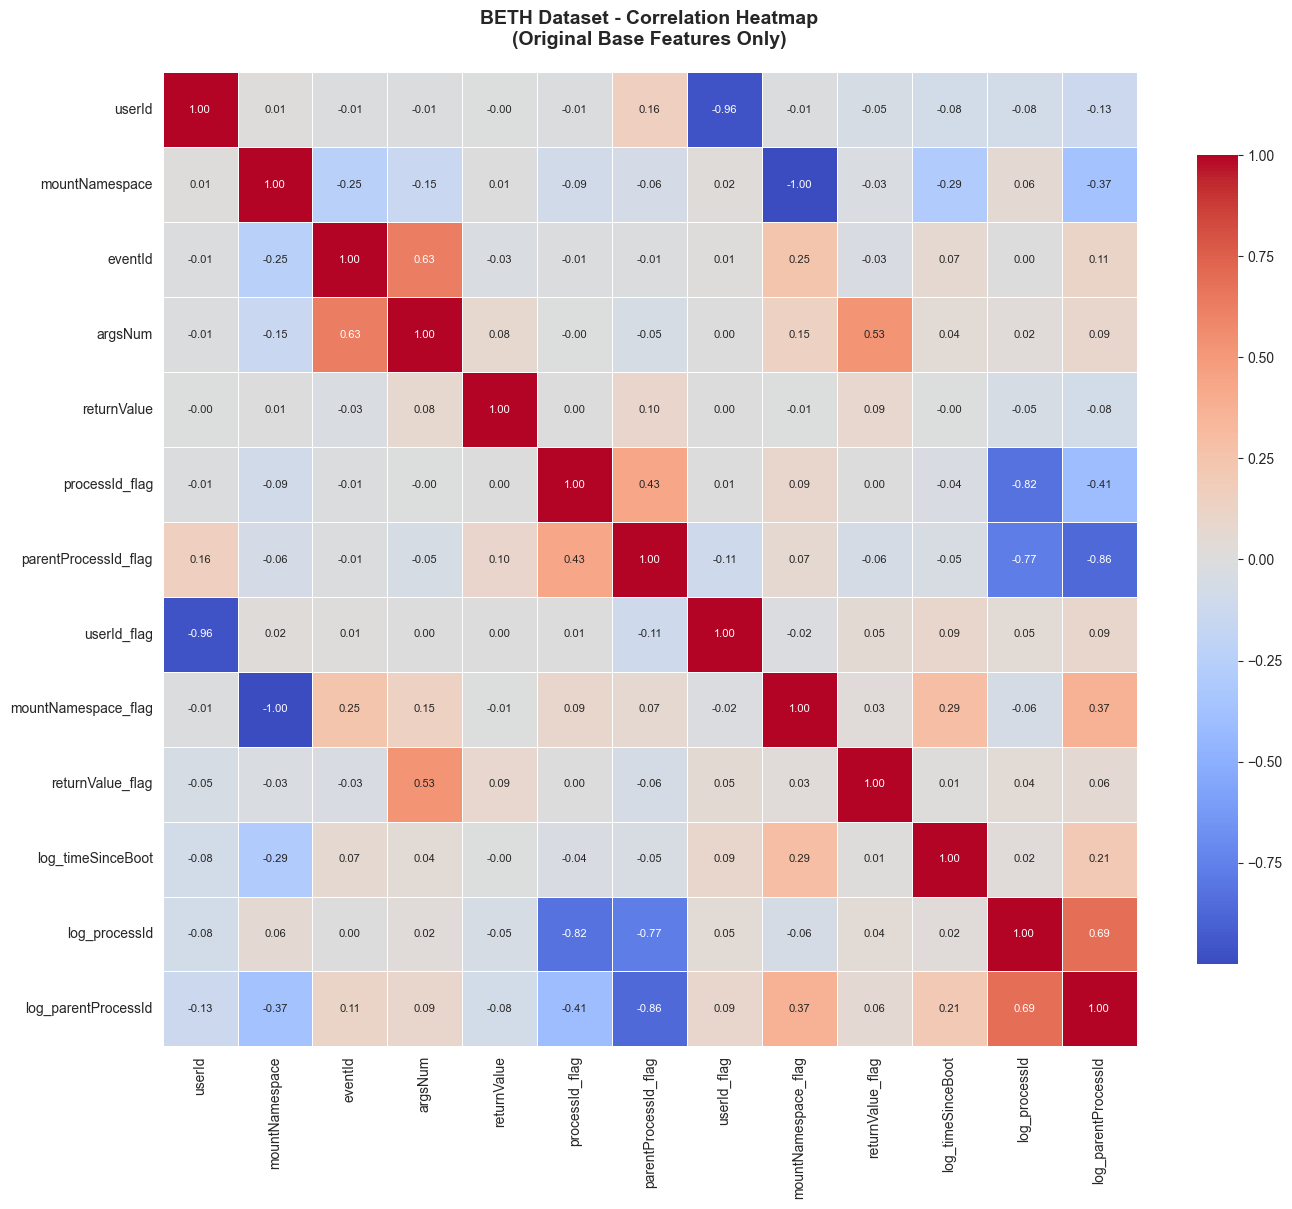


[BETH - Strongest Correlations Between Base Features (|r| ≥ 0.3)]
mountNamespace        mountNamespace_flag     0.999901
mountNamespace_flag   mountNamespace          0.999901
userId                userId_flag             0.963952
userId_flag           userId                  0.963952
log_parentProcessId   parentProcessId_flag    0.863195
parentProcessId_flag  log_parentProcessId     0.863195
log_processId         processId_flag          0.822830
processId_flag        log_processId           0.822830
log_processId         parentProcessId_flag    0.772607
parentProcessId_flag  log_processId           0.772607
log_parentProcessId   log_processId           0.689516
log_processId         log_parentProcessId     0.689516
argsNum               eventId                 0.631485
eventId               argsNum                 0.631485
argsNum               returnValue_flag        0.526433
dtype: float64

   Total pairs with |r| ≥ 0.3: 24


In [ ]:
# BETH Correlation heatmap (base features only - excluding engineered derivatives)
# Exclude target variables (sus, evil) from feature analysis
target_cols = ['sus', 'evil']
numeric_features = beth_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_features = [col for col in numeric_features if col not in target_cols]

# Exclude feature-engineered derivatives to show only original base features
engineered_patterns = ['_sum', '_diff', '_ratio', 'both_zero', 'one_zero', 
                       'src_dst', 'dst_src', 'total_', 'is_', 'sum_', 'diff_', 'ratio_']
base_features = [col for col in numeric_features 
                 if not any(pattern in col for pattern in engineered_patterns)]

print(f"[INFO] Total numeric features: {len(numeric_features)}")
print(f"[INFO] Base features (excluding engineered): {len(base_features)}")

if len(base_features) > 20:
    # Select top 20 features with highest variance
    variances = beth_train[base_features].var().sort_values(ascending=False)
    top_features = variances.head(20).index.tolist()
else:
    top_features = base_features

print(f"[INFO] Analyzing correlations for {len(top_features)} base features (excluding target labels)")

plt.figure(figsize=(14, 12))
correlation_matrix = beth_train[top_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, 
            annot_kws={'fontsize': 8})
plt.title('BETH Dataset - Correlation Heatmap\n(Original Base Features Only)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Display strongest correlations
corr_pairs = correlation_matrix.abs().unstack()
corr_pairs = corr_pairs[(corr_pairs < 1.0) & (corr_pairs >= 0.3)].sort_values(ascending=False)
print("\n[BETH - Strongest Correlations Between Base Features (|r| ≥ 0.3)]")
if len(corr_pairs) > 0:
    print(corr_pairs.head(15))
    print(f"\n   Total pairs with |r| ≥ 0.3: {len(corr_pairs)}")
else:
    print("   No moderate-to-strong correlations found.")
    print("   Features are largely independent!")

In [ ]:
# BETH Data Quality Checks
print("="*80)
print("BETH DATASET - DATA QUALITY CHECKS")
print("="*80)

# 1. Check for duplicate rows
print("\n[1. Duplicate Row Detection]")
beth_train_dupes = beth_train.duplicated().sum()
beth_val_dupes = beth_val.duplicated().sum()
beth_test_dupes = beth_test.duplicated().sum()

print(f"   Training Set Duplicates:   {beth_train_dupes:6d} ({100*beth_train_dupes/len(beth_train):5.2f}%)")
print(f"   Validation Set Duplicates: {beth_val_dupes:6d} ({100*beth_val_dupes/len(beth_val):5.2f}%)")
print(f"   Test Set Duplicates:       {beth_test_dupes:6d} ({100*beth_test_dupes/len(beth_test):5.2f}%)")

# 2. Check for infinite values
print("\n[2. Infinite Value Detection]")
numeric_cols = beth_train.select_dtypes(include=['float64', 'int64']).columns
inf_counts = {}
for col in numeric_cols:
    inf_count = np.isinf(beth_train[col]).sum()
    if inf_count > 0:
        inf_counts[col] = inf_count

if inf_counts:
    print("   Features with infinite values:")
    for col, count in inf_counts.items():
        print(f"      {col}: {count}")
else:
    print("   No infinite values found!")

# 3. Check for negative values in features that should be non-negative
print("\n[3. Negative Value Detection]")
# Identify columns that should be non-negative (counts, sizes, durations, etc.)
potential_nonneg_cols = [col for col in numeric_cols if any(keyword in col.lower() 
                         for keyword in ['count', 'size', 'duration', 'length', 'bytes', 'packets'])]

negative_features = {}
for col in potential_nonneg_cols:
    neg_count = (beth_train[col] < 0).sum()
    if neg_count > 0:
        negative_features[col] = neg_count

if negative_features:
    print("   Features with unexpected negative values:")
    for col, count in negative_features.items():
        print(f"      {col}: {count} ({100*count/len(beth_train):.2f}%)")
else:
    print("   No unexpected negative values found!")

# 4. Check for constant/zero-variance features
print("\n[4. Zero-Variance Feature Detection]")
zero_var_features = []
for col in numeric_cols:
    if beth_train[col].nunique() == 1:
        zero_var_features.append(col)

if zero_var_features:
    print(f"   Found {len(zero_var_features)} zero-variance features:")
    for col in zero_var_features[:10]:  # Show first 10
        print(f"      {col}: constant value = {beth_train[col].iloc[0]}")
    if len(zero_var_features) > 10:
        print(f"      ... and {len(zero_var_features) - 10} more")
else:
    print("   No zero-variance features found!")

# 5. Summary statistics
print("\n[5. Data Quality Summary]")
total_cells = beth_train.shape[0] * beth_train.shape[1]
null_cells = beth_train.isnull().sum().sum()
print(f"   Total data cells:     {total_cells:,}")
print(f"   Null cells:           {null_cells:,} ({100*null_cells/total_cells:.4f}%)")
print(f"   Complete cells:       {total_cells - null_cells:,} ({100*(total_cells-null_cells)/total_cells:.4f}%)")
print(f"   Duplicate rows:       {beth_train_dupes:,}")
print(f"   Zero-variance cols:   {len(zero_var_features)}")

print("\n" + "="*80)

BETH DATASET - DATA QUALITY CHECKS

[1. Duplicate Row Detection]
   Training Set Duplicates:        0 ( 0.00%)
   Validation Set Duplicates:      0 ( 0.00%)
   Test Set Duplicates:            0 ( 0.00%)

[2. Infinite Value Detection]
   No infinite values found!

[3. Negative Value Detection]
   No unexpected negative values found!

[4. Zero-Variance Feature Detection]
   Found 1 zero-variance features:
      evil: constant value = 0.0

[5. Data Quality Summary]
   Total data cells:     12,973,448
   Null cells:           0 (0.0000%)
   Complete cells:       12,973,448 (100.0000%)
   Duplicate rows:       0
   Zero-variance cols:   1

   Training Set Duplicates:        0 ( 0.00%)
   Validation Set Duplicates:      0 ( 0.00%)
   Test Set Duplicates:            0 ( 0.00%)

[2. Infinite Value Detection]
   No infinite values found!

[3. Negative Value Detection]
   No unexpected negative values found!

[4. Zero-Variance Feature Detection]
   Found 1 zero-variance features:
      evil: con

### 3.1. BETH Feature Distributions

Analyze the distribution of key numeric features to understand data characteristics and identify potential outliers.

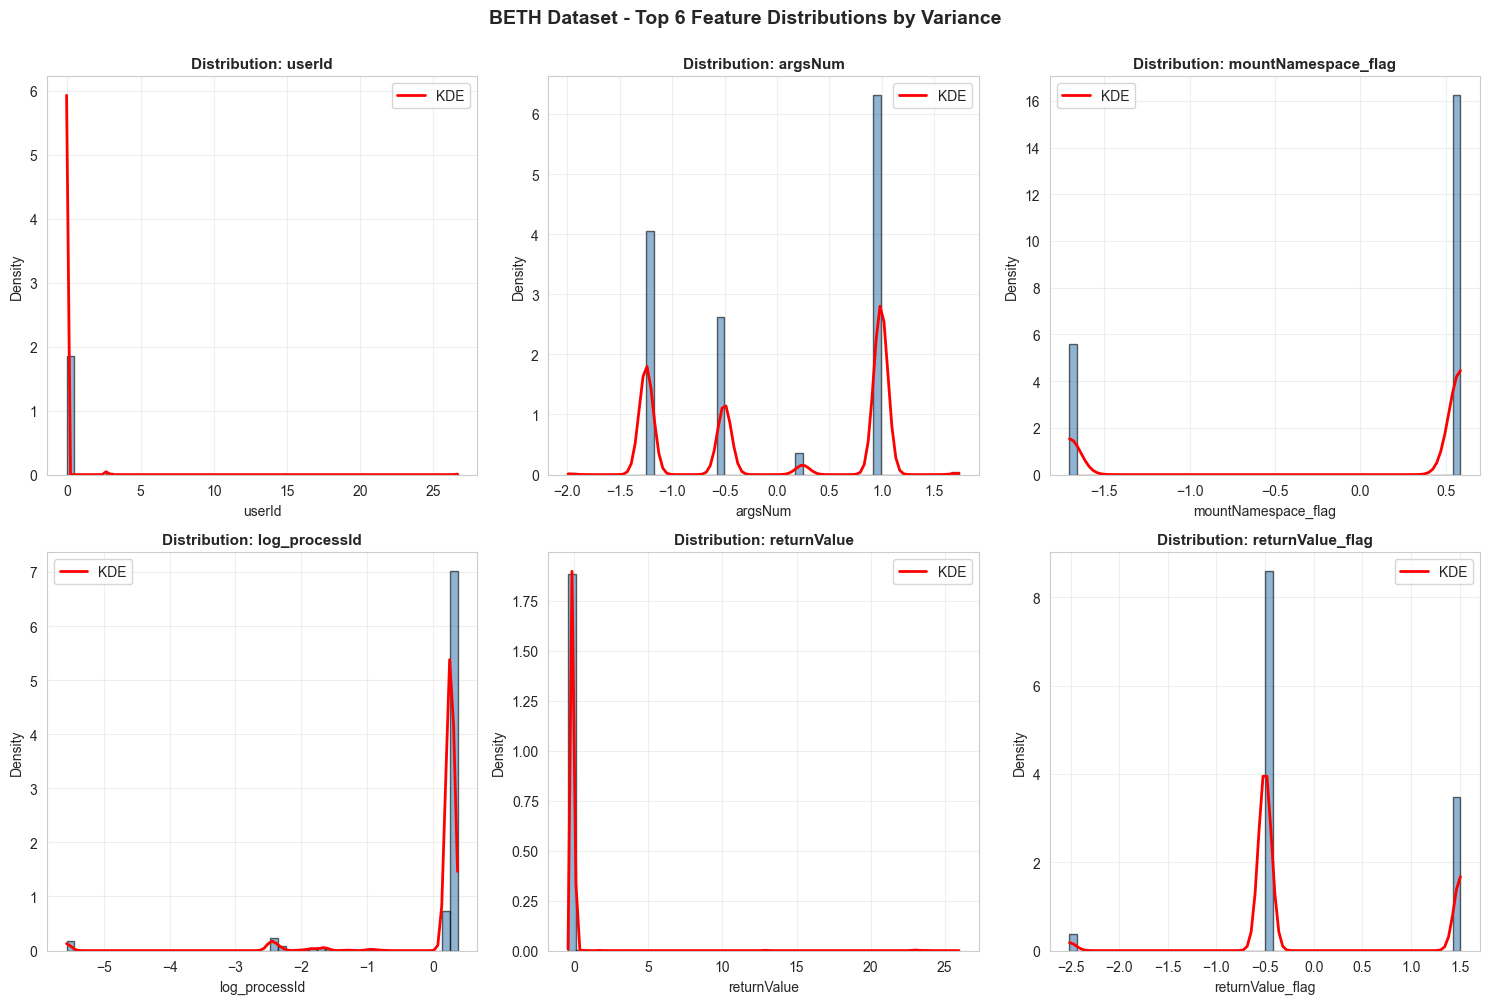

[INFO] Displayed distributions for top 6 features by variance
[INFO] Features: userId, argsNum, mountNamespace_flag, log_processId, returnValue, returnValue_flag


In [ ]:
# Visualize distributions of top features by variance
target_cols = ['sus', 'evil']
numeric_features = beth_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_features = [col for col in numeric_features if col not in target_cols]

# Select top 6 features by variance for visualization
variances = beth_train[numeric_features].var().sort_values(ascending=False)
top_6_features = variances.head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_6_features):
    # Histogram with KDE
    axes[idx].hist(beth_train[feature], bins=50, alpha=0.6, color='steelblue', edgecolor='black', density=True)
    
    # Add KDE curve
    from scipy.stats import gaussian_kde
    try:
        kde = gaussian_kde(beth_train[feature].dropna())
        x_range = np.linspace(beth_train[feature].min(), beth_train[feature].max(), 100)
        axes[idx].plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
    except:
        pass
    
    axes[idx].set_xlabel(feature, fontsize=10)
    axes[idx].set_ylabel('Density', fontsize=10)
    axes[idx].set_title(f'Distribution: {feature}', fontsize=11, fontweight='bold')
    axes[idx].grid(alpha=0.3)
    axes[idx].legend()

plt.suptitle('BETH Dataset - Top 6 Feature Distributions by Variance', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"[INFO] Displayed distributions for top 6 features by variance")
print(f"[INFO] Features: {', '.join(top_6_features)}")

### 3.2. BETH Data Quality Checks

Perform comprehensive data quality validation including duplicates, value ranges, and data type consistency.

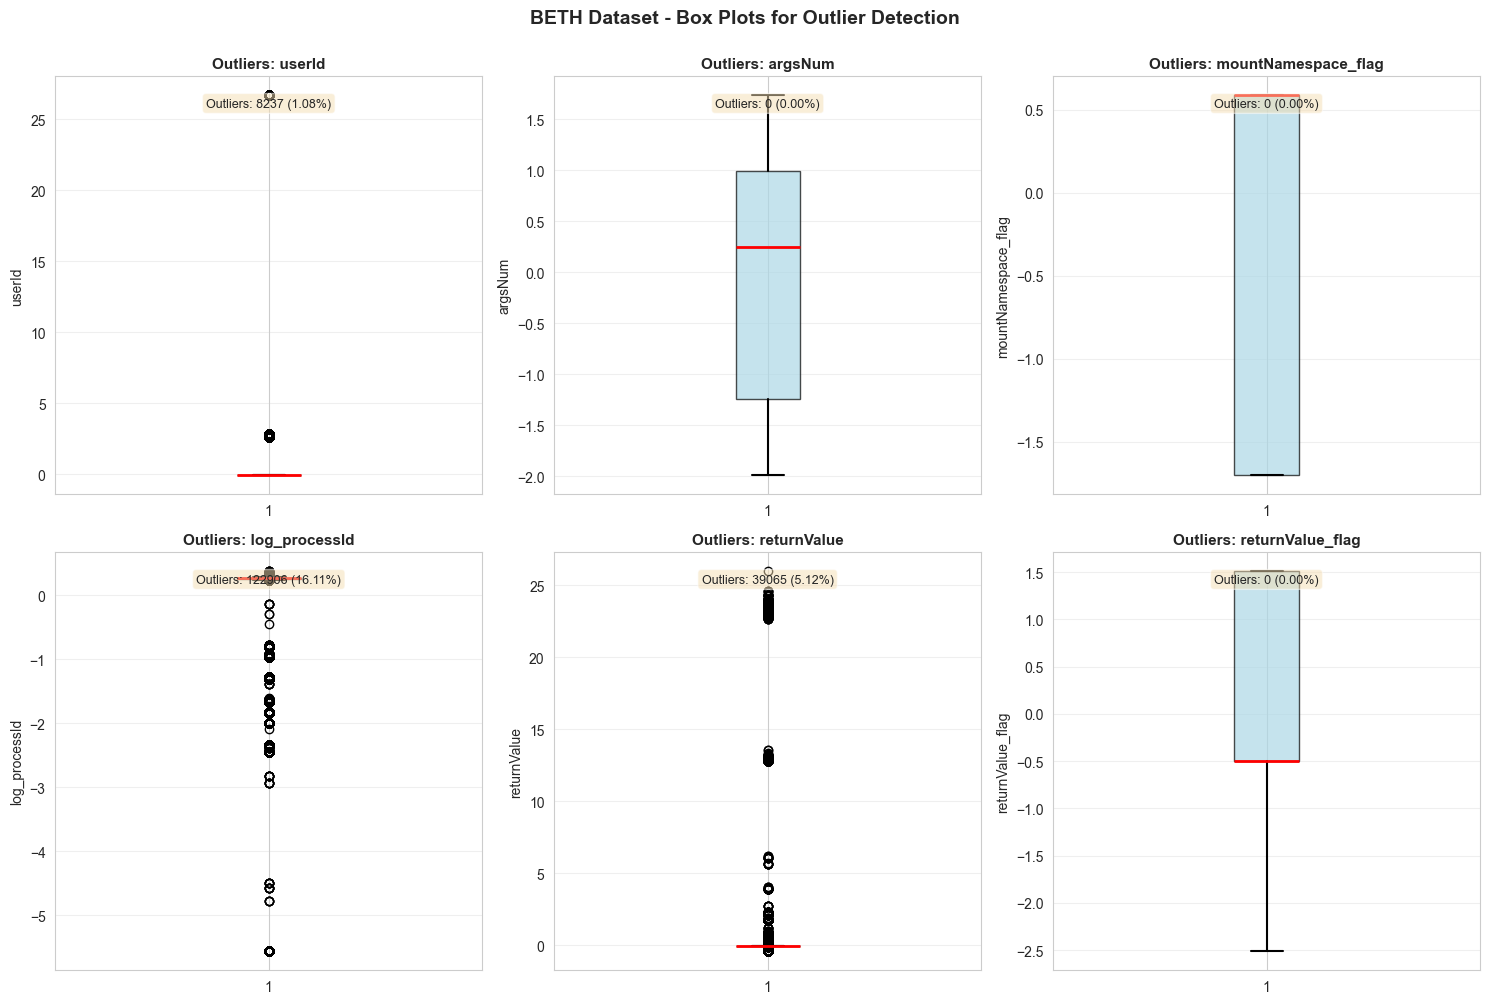

In [ ]:
# Box plots to identify outliers in top features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_6_features):
    bp = axes[idx].boxplot(beth_train[feature].dropna(), vert=True, patch_artist=True,
                            boxprops=dict(facecolor='lightblue', alpha=0.7),
                            medianprops=dict(color='red', linewidth=2),
                            whiskerprops=dict(color='black', linewidth=1.5),
                            capprops=dict(color='black', linewidth=1.5))
    
    axes[idx].set_ylabel(feature, fontsize=10)
    axes[idx].set_title(f'Outliers: {feature}', fontsize=11, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Calculate and display outlier statistics
    Q1 = beth_train[feature].quantile(0.25)
    Q3 = beth_train[feature].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((beth_train[feature] < (Q1 - 1.5 * IQR)) | (beth_train[feature] > (Q3 + 1.5 * IQR))).sum()
    outlier_pct = 100 * outliers / len(beth_train)
    
    axes[idx].text(0.5, 0.95, f'Outliers: {outliers} ({outlier_pct:.2f}%)', 
                   transform=axes[idx].transAxes, ha='center', va='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=9)

plt.suptitle('BETH Dataset - Box Plots for Outlier Detection', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 4. UNSW-NB15 Dataset Overview

**UNSW-NB15** is a comprehensive network traffic dataset created by the Cyber Range Lab at UNSW Canberra. It contains both normal network activities and modern attack behaviors for **supervised attack classification**.

### Key Characteristics:
- **Training Set**: Balanced mix of normal and attack traffic
- **Test Set**: Independent test data for evaluation
- **Attack Types**: Multiple categories (DoS, Exploits, Generic, Reconnaissance, etc.)
- **Features**: Network flow statistics, packet-level features, protocol information
- **Binary Classification**: Normal vs Attack
- **Multi-class Classification**: Specific attack types

In [ ]:
# Display basic statistics for UNSW-NB15 datasets
print("="*80)
print("UNSW-NB15 DATASET - BASIC STATISTICS")
print("="*80)

print("\n[UNSW-NB15 Training Set]")
print(f"   Shape: {unsw_train.shape}")
print(f"   Memory Usage: {unsw_train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n[UNSW-NB15 Test Set]")
print(f"   Shape: {unsw_test.shape}")
print(f"   Memory Usage: {unsw_test.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n" + "="*80)

# Display sample of training data
print("\n[Sample of UNSW-NB15 Training Data]")
print(unsw_train.head(10))

# Check for null values
print("\n[UNSW-NB15 Training Set - Null Values]")
null_counts = unsw_train.isnull().sum()
if null_counts.sum() > 0:
    print(null_counts[null_counts > 0])
else:
    print("   No null values found!")

# Check for target distribution
if 'label' in unsw_train.columns:
    print("\n[UNSW-NB15 Training Set - Class Distribution (Binary)]")
    label_counts = unsw_train['label'].value_counts().sort_index()
    total = len(unsw_train)
    for label, count in label_counts.items():
        label_name = "Normal" if label == 0 else "Attack"
        print(f"   {label_name} ({label}): {count:6d} ({100*count/total:5.2f}%)")

if 'attack_cat' in unsw_train.columns:
    print("\n[UNSW-NB15 Training Set - Attack Type Distribution]")
    attack_counts = unsw_train['attack_cat'].value_counts()
    total = len(unsw_train)
    for attack_type, count in attack_counts.items():
        print(f"   {str(attack_type):20s}: {count:6d} ({100*count/total:5.2f}%)")

UNSW-NB15 DATASET - BASIC STATISTICS

[UNSW-NB15 Training Set]
   Shape: (82332, 123)
   Memory Usage: 91.32 MB

[UNSW-NB15 Test Set]
   Shape: (175341, 123)
   Memory Usage: 194.55 MB


[Sample of UNSW-NB15 Training Data]
   id proto service state          rate     sinpkt  dinpkt  swin  stcpb  \
0   1   udp       -   INT   90909.09020      0.011     0.0     0      0   
1   2   udp       -   INT  125000.00030      0.008     0.0     0      0   
2   3   udp       -   INT  200000.00510      0.005     0.0     0      0   
3   4   udp       -   INT  166666.66080      0.006     0.0     0      0   
4   5   udp       -   INT  100000.00250      0.010     0.0     0      0   
5   6   udp       -   INT  333333.32150      0.003     0.0     0      0   
6   7   udp       -   INT  166666.66080      0.006     0.0     0      0   
7   8   udp       -   INT   35714.28522      0.028     0.0     0      0   
8   9   arp       -   INT       0.00000  60000.688     0.0     0      0   
9  10   arp       -   INT  

In [ ]:
# Analyze UNSW-NB15 column types
print("\n[UNSW-NB15 Training Set - Feature Types]")
print(f"   Total Features: {len(unsw_train.columns)}")

# Separate numeric and categorical (excluding targets)
exclude_cols = ['label', 'attack_cat'] if 'attack_cat' in unsw_train.columns else ['label']
feature_cols = [col for col in unsw_train.columns if col not in exclude_cols]

numeric_cols = unsw_train[feature_cols].select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = unsw_train[feature_cols].select_dtypes(include=['object', 'category']).columns.tolist()

print(f"   Numeric Features: {len(numeric_cols)}")
print(f"   Categorical Features: {len(categorical_cols)}")
print(f"   Target Variables: {len(exclude_cols)}")

# Display data types
print("\n[UNSW-NB15 Data Types]")
print(unsw_train.dtypes.value_counts())

# Display numeric statistics for select features
print("\n[UNSW-NB15 Numeric Features - Statistics (Sample)]")
sample_features = numeric_cols[:10] if len(numeric_cols) > 10 else numeric_cols
print(unsw_train[sample_features].describe().T)


[UNSW-NB15 Training Set - Feature Types]
   Total Features: 123
   Numeric Features: 118
   Categorical Features: 3
   Target Variables: 2

[UNSW-NB15 Data Types]
int64      63
float64    56
object      4
Name: count, dtype: int64

[UNSW-NB15 Numeric Features - Statistics (Sample)]
          count          mean           std  min           25%           50%  \
id      82332.0  4.116650e+04  2.376735e+04  1.0  20583.750000  4.116650e+04   
rate    82332.0  8.241089e+04  1.486204e+05  0.0     28.606114  2.650177e+03   
sinpkt  82332.0  7.553943e+02  6.182616e+03  0.0      0.008000  5.579285e-01   
dinpkt  82332.0  1.217013e+02  1.292378e+03  0.0      0.000000  1.000000e-02   
swin    82332.0  1.334591e+02  1.273570e+02  0.0      0.000000  2.550000e+02   
stcpb   82332.0  1.084642e+09  1.390860e+09  0.0      0.000000  2.788886e+07   
dtcpb   82332.0  1.073465e+09  1.381996e+09  0.0      0.000000  2.856975e+07   
dwin    82332.0  1.282866e+02  1.274914e+02  0.0      0.000000  2.550000e+02

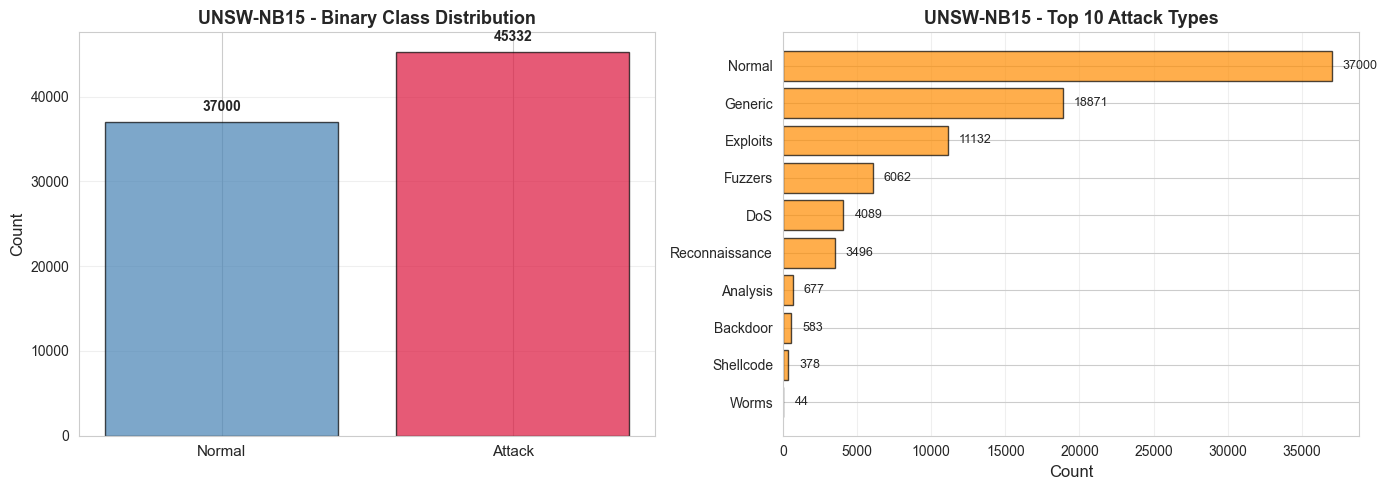

In [ ]:
# Visualize class distribution for UNSW-NB15
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes = axes.flatten()

# Binary classification distribution
if 'label' in unsw_train.columns:
    label_counts = unsw_train['label'].value_counts().sort_index()
    labels_names = ['Normal', 'Attack']
    colors = ['steelblue', 'crimson']
    
    axes[0].bar(range(len(label_counts)), label_counts.values, color=colors, alpha=0.7, edgecolor='black')
    axes[0].set_xticks(range(len(label_counts)))
    axes[0].set_xticklabels(labels_names, fontsize=11)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].set_title('UNSW-NB15 - Binary Class Distribution', fontsize=13, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Add count labels on bars
    for i, v in enumerate(label_counts.values):
        axes[0].text(i, v + max(label_counts.values)*0.02, str(v), 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Attack type distribution
if 'attack_cat' in unsw_train.columns:
    attack_counts = unsw_train['attack_cat'].value_counts().head(10)
    
    axes[1].barh(range(len(attack_counts)), attack_counts.values, color='darkorange', alpha=0.7, edgecolor='black')
    axes[1].set_yticks(range(len(attack_counts)))
    axes[1].set_yticklabels(attack_counts.index, fontsize=10)
    axes[1].set_xlabel('Count', fontsize=12)
    axes[1].set_title('UNSW-NB15 - Top 10 Attack Types', fontsize=13, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    axes[1].invert_yaxis()
    
    # Add count labels
    for i, v in enumerate(attack_counts.values):
        axes[1].text(v + max(attack_counts.values)*0.02, i, str(v), 
                    ha='left', va='center', fontsize=9)
else:
    axes[1].text(0.5, 0.5, 'No attack_cat column found', 
                ha='center', va='center', transform=axes[1].transAxes)
    axes[1].axis('off')

plt.tight_layout()
plt.show()

[INFO] Total numeric features: 118
[INFO] Base features (excluding all engineered): 37

[INFO] Base features included:
   - ackdat
   - dinpkt
   - dmean
   - dtcpb
   - dwin
   - id
   - log_ct_dst_ltm
   - log_ct_dst_sport_ltm
   - log_ct_flw_http_mthd
   - log_ct_ftp_cmd
   - log_ct_src_dport_ltm
   - log_ct_src_ltm
   - log_ct_srv_dst
   - log_ct_srv_src
   - log_ct_state_ttl
   - log_dbytes
   - log_djit
   - log_dload
   - log_dloss
   - log_dpkts
   - log_dttl
   - log_dur
   - log_sbytes
   - log_sjit
   - log_sload
   - log_sloss
   - log_spkts
   - log_sttl
   - rate
   - response_body_len
   ... and 7 more

[INFO] Top 20 features by variance selected for correlation heatmap


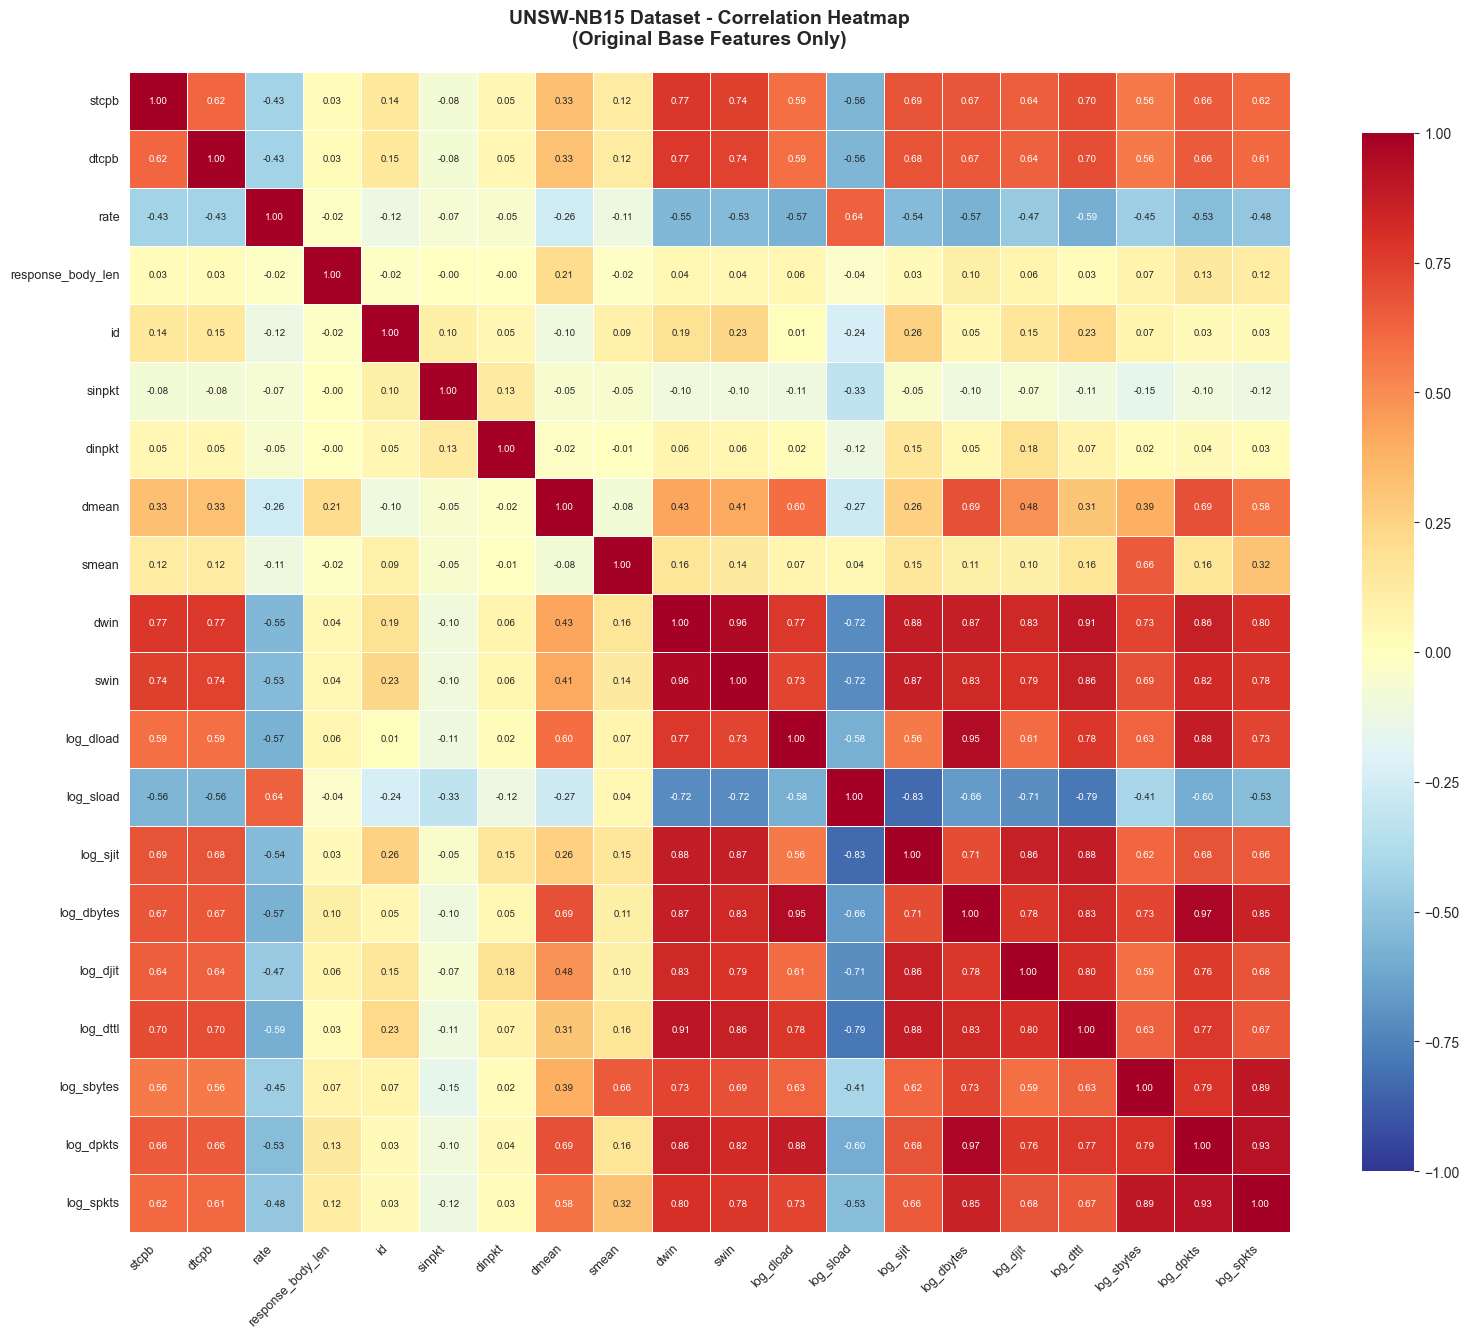


[UNSW-NB15 - Strongest Correlations Between Base Features (|r| ≥ 0.3)]
log_dbytes  log_dpkts     0.971748
log_dpkts   log_dbytes    0.971748
dwin        swin          0.960125
swin        dwin          0.960125
log_dbytes  log_dload     0.946300
log_dload   log_dbytes    0.946300
log_dpkts   log_spkts     0.926283
log_spkts   log_dpkts     0.926283
dwin        log_dttl      0.906268
log_dttl    dwin          0.906268
log_sbytes  log_spkts     0.894719
log_spkts   log_sbytes    0.894719
log_sjit    dwin          0.882092
dwin        log_sjit      0.882092
log_dttl    log_sjit      0.881821
log_sjit    log_dttl      0.881821
log_dpkts   log_dload     0.881140
log_dload   log_dpkts     0.881140
dwin        log_dbytes    0.873629
log_dbytes  dwin          0.873629
dtype: float64

   Total pairs with |r| ≥ 0.3: 210


In [ ]:
# UNSW-NB15 Correlation heatmap (base features only - excluding all engineered derivatives)
exclude_cols = ['label', 'attack_cat'] if 'attack_cat' in unsw_train.columns else ['label']
numeric_features = unsw_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_features = [col for col in numeric_features if col not in exclude_cols]

# Exclude ALL feature-engineered derivatives to show only original base features
# Patterns to exclude: sum/diff/ratio features, zero flags, and other derived features
engineered_patterns = ['_sum', '_diff', '_ratio', 'both_zero', 'one_zero', 
                       'src_dst', 'dst_src', 'total_', 'is_', 'sum_', 'diff_', 'ratio_']
base_features = [col for col in numeric_features 
                 if not any(pattern in col for pattern in engineered_patterns)]

print(f"[INFO] Total numeric features: {len(numeric_features)}")
print(f"[INFO] Base features (excluding all engineered): {len(base_features)}")
print(f"\n[INFO] Base features included:")
for feat in sorted(base_features)[:30]:  # Show first 30
    print(f"   - {feat}")
if len(base_features) > 30:
    print(f"   ... and {len(base_features) - 30} more")

if len(base_features) > 20:
    # Select top 20 base features with highest variance
    variances = unsw_train[base_features].var().sort_values(ascending=False)
    top_features = variances.head(20).index.tolist()
else:
    top_features = base_features

print(f"\n[INFO] Top {len(top_features)} features by variance selected for correlation heatmap")

plt.figure(figsize=(16, 14))
correlation_matrix = unsw_train[top_features].corr()

# Create a more informative visualization
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, 
            vmin=-1, vmax=1, annot_kws={'fontsize': 7})
plt.title('UNSW-NB15 Dataset - Correlation Heatmap\n(Original Base Features Only)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

# Display strongest correlations between distinct base features
corr_pairs = correlation_matrix.abs().unstack()
# Exclude self-correlations and show moderate-to-strong correlations
corr_pairs = corr_pairs[(corr_pairs < 1.0) & (corr_pairs >= 0.3)].sort_values(ascending=False)
print("\n[UNSW-NB15 - Strongest Correlations Between Base Features (|r| ≥ 0.3)]")
if len(corr_pairs) > 0:
    print(corr_pairs.head(20))
    print(f"\n   Total pairs with |r| ≥ 0.3: {len(corr_pairs)}")
else:
    print("   No moderate-to-strong correlations found between base features.")
    print("   This suggests features are largely independent!")


FEATURE CORRELATION WITH TARGET VARIABLE

[Top 20 Features Most Correlated with Attack Label]
                       Feature  Correlation
                     log_dload    -0.533314
               ratio_sttl_dttl     0.518790
            one_zero_sttl_dttl     0.517121
          one_zero_sload_dload     0.515242
                      log_sttl     0.504177
        one_zero_sbytes_dbytes     0.491641
          one_zero_spkts_dpkts     0.491641
          one_zero_smean_dmean     0.491641
        one_zero_sinpkt_dinpkt     0.491548
              log_ct_state_ttl     0.484002
          log_ct_dst_sport_ltm     0.482702
          log_diff_sload_dload     0.467762
  is_integer_ratio_smean_dmean     0.466082
                    log_dbytes    -0.456053
  is_integer_ratio_sload_dload     0.454925
    is_integer_ratio_sttl_dttl     0.445700
           both_zero_swin_dwin     0.414626
                          swin    -0.414504
         both_zero_sloss_dloss     0.414303
is_integer_ratio_sbytes_d

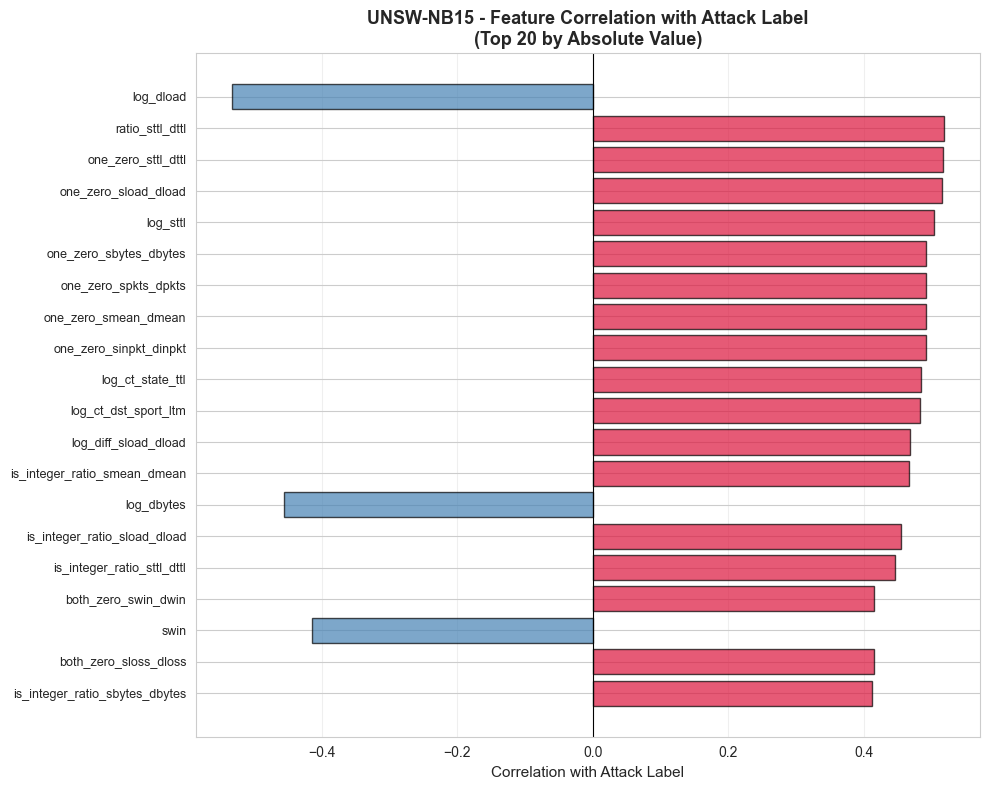


[INFO] Red bars = positive correlation (higher values indicate attacks)
[INFO] Blue bars = negative correlation (higher values indicate normal traffic)



In [ ]:
# Correlation with Target Variable (UNSW-NB15)
print("\n" + "="*80)
print("FEATURE CORRELATION WITH TARGET VARIABLE")
print("="*80)

if 'label' in unsw_train.columns:
    # Calculate correlation between features and binary label
    numeric_features_for_corr = unsw_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
    # Remove target columns
    exclude_cols = ['label', 'attack_cat'] if 'attack_cat' in unsw_train.columns else ['label']
    numeric_features_for_corr = [col for col in numeric_features_for_corr if col not in exclude_cols]
    
    # Calculate correlations
    target_correlations = {}
    for col in numeric_features_for_corr:
        corr = unsw_train[col].corr(unsw_train['label'])
        target_correlations[col] = corr
    
    # Sort by absolute correlation
    target_corr_df = pd.DataFrame(list(target_correlations.items()), 
                                   columns=['Feature', 'Correlation'])
    target_corr_df['Abs_Correlation'] = target_corr_df['Correlation'].abs()
    target_corr_df = target_corr_df.sort_values('Abs_Correlation', ascending=False)
    
    print("\n[Top 20 Features Most Correlated with Attack Label]")
    print(target_corr_df.head(20)[['Feature', 'Correlation']].to_string(index=False))
    
    # Visualize top correlations
    top_20_corr = target_corr_df.head(20)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = ['crimson' if x > 0 else 'steelblue' for x in top_20_corr['Correlation']]
    ax.barh(range(len(top_20_corr)), top_20_corr['Correlation'], color=colors, alpha=0.7, edgecolor='black')
    ax.set_yticks(range(len(top_20_corr)))
    ax.set_yticklabels(top_20_corr['Feature'], fontsize=9)
    ax.set_xlabel('Correlation with Attack Label', fontsize=11)
    ax.set_title('UNSW-NB15 - Feature Correlation with Attack Label\n(Top 20 by Absolute Value)', 
                 fontsize=13, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n[INFO] Red bars = positive correlation (higher values indicate attacks)")
    print(f"[INFO] Blue bars = negative correlation (higher values indicate normal traffic)")

print("\n" + "="*80)

In [ ]:
# UNSW-NB15 Data Quality Checks
print("="*80)
print("UNSW-NB15 DATASET - DATA QUALITY CHECKS")
print("="*80)

# 1. Check for duplicate rows
print("\n[1. Duplicate Row Detection]")
unsw_train_dupes = unsw_train.duplicated().sum()
unsw_test_dupes = unsw_test.duplicated().sum()

print(f"   Training Set Duplicates: {unsw_train_dupes:6d} ({100*unsw_train_dupes/len(unsw_train):5.2f}%)")
print(f"   Test Set Duplicates:     {unsw_test_dupes:6d} ({100*unsw_test_dupes/len(unsw_test):5.2f}%)")

# 2. Check for infinite values
print("\n[2. Infinite Value Detection]")
numeric_cols = unsw_train.select_dtypes(include=['float64', 'int64']).columns
exclude_cols = ['label', 'attack_cat'] if 'attack_cat' in unsw_train.columns else ['label']
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

inf_counts = {}
for col in numeric_cols:
    inf_count = np.isinf(unsw_train[col]).sum()
    if inf_count > 0:
        inf_counts[col] = inf_count

if inf_counts:
    print("   Features with infinite values:")
    for col, count in inf_counts.items():
        print(f"      {col}: {count}")
else:
    print("   No infinite values found!")

# 3. Check for negative values in features that should be non-negative
print("\n[3. Negative Value Detection]")
# Network features that should be non-negative
potential_nonneg_cols = [col for col in numeric_cols if any(keyword in col.lower() 
                         for keyword in ['bytes', 'packets', 'pkts', 'dur', 'ttl', 'count', 'rate', 'load'])]

negative_features = {}
for col in potential_nonneg_cols:
    neg_count = (unsw_train[col] < 0).sum()
    if neg_count > 0:
        negative_features[col] = neg_count

if negative_features:
    print("   Features with unexpected negative values:")
    for col, count in negative_features.items():
        print(f"      {col}: {count} ({100*count/len(unsw_train):.2f}%)")
else:
    print("   No unexpected negative values found!")

# 4. Check for constant/zero-variance features
print("\n[4. Zero-Variance Feature Detection]")
zero_var_features = []
for col in numeric_cols:
    if unsw_train[col].nunique() == 1:
        zero_var_features.append(col)

if zero_var_features:
    print(f"   Found {len(zero_var_features)} zero-variance features:")
    for col in zero_var_features[:10]:  # Show first 10
        print(f"      {col}: constant value = {unsw_train[col].iloc[0]}")
    if len(zero_var_features) > 10:
        print(f"      ... and {len(zero_var_features) - 10} more")
else:
    print("   No zero-variance features found!")

# 5. Class balance check
if 'label' in unsw_train.columns:
    print("\n[5. Class Balance Analysis]")
    label_counts = unsw_train['label'].value_counts()
    total = len(unsw_train)
    
    for label in sorted(label_counts.index):
        label_name = "Normal" if label == 0 else "Attack"
        count = label_counts[label]
        print(f"   {label_name} ({label}): {count:6d} ({100*count/total:5.2f}%)")
    
    # Calculate imbalance ratio
    if len(label_counts) == 2:
        imbalance_ratio = label_counts.max() / label_counts.min()
        print(f"   Imbalance Ratio: {imbalance_ratio:.2f}:1")

# 6. Summary statistics
print("\n[6. Data Quality Summary]")
total_cells = unsw_train.shape[0] * unsw_train.shape[1]
null_cells = unsw_train.isnull().sum().sum()
print(f"   Total data cells:     {total_cells:,}")
print(f"   Null cells:           {null_cells:,} ({100*null_cells/total_cells:.4f}%)")
print(f"   Complete cells:       {total_cells - null_cells:,} ({100*(total_cells-null_cells)/total_cells:.4f}%)")
print(f"   Duplicate rows:       {unsw_train_dupes:,}")
print(f"   Zero-variance cols:   {len(zero_var_features)}")

print("\n" + "="*80)

UNSW-NB15 DATASET - DATA QUALITY CHECKS

[1. Duplicate Row Detection]
   Training Set Duplicates:      0 ( 0.00%)
   Test Set Duplicates:          0 ( 0.00%)

[2. Infinite Value Detection]
   No infinite values found!

[3. Negative Value Detection]
   Features with unexpected negative values:
      log_diff_spkts_dpkts: 11926 (14.49%)
      log_diff_sbytes_dbytes: 21050 (25.57%)
      log_diff_sttl_dttl: 10367 (12.59%)
      log_diff_sload_dload: 21033 (25.55%)

[4. Zero-Variance Feature Detection]
   Found 9 zero-variance features:
      both_zero_spkts_dpkts: constant value = 0
      both_zero_sbytes_dbytes: constant value = 0
      both_zero_smean_dmean: constant value = 0
      both_zero_ct_srv_src_ct_srv_dst: constant value = 0
      one_zero_ct_srv_src_ct_srv_dst: constant value = 0
      both_zero_ct_src_dport_ltm_ct_dst_sport_ltm: constant value = 0
      one_zero_ct_src_dport_ltm_ct_dst_sport_ltm: constant value = 0
      both_zero_ct_src_ltm_ct_dst_ltm: constant value = 0
   

### 4.1. UNSW-NB15 Feature Distributions

Analyze the distribution of key numeric features to understand data characteristics and identify potential outliers.

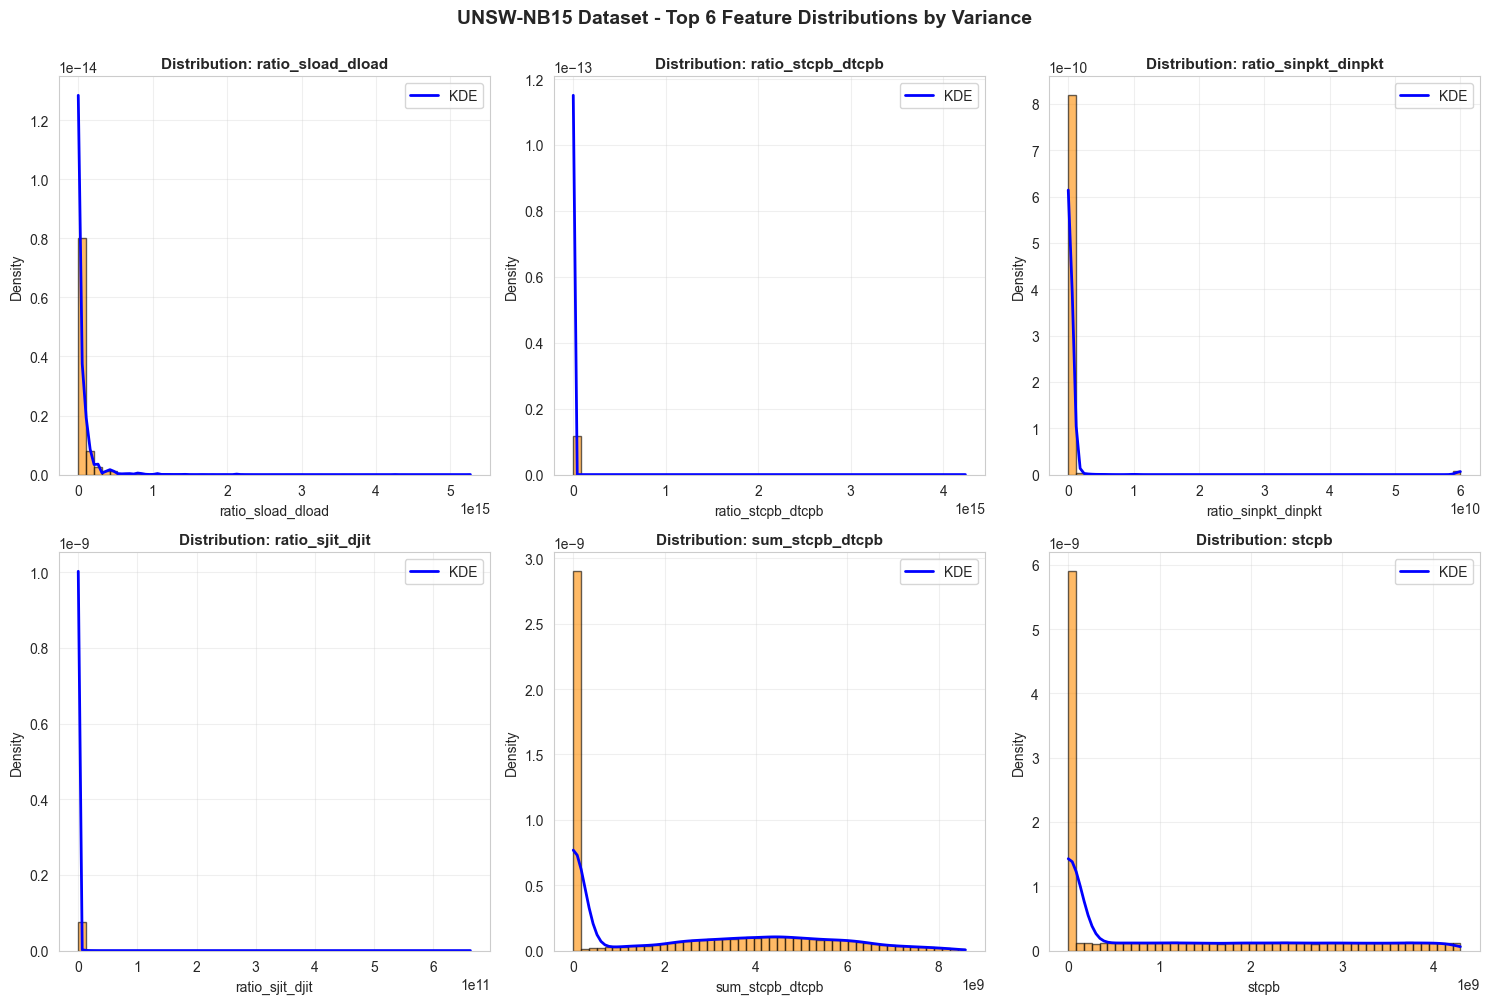

[INFO] Displayed distributions for top 6 features by variance
[INFO] Features: ratio_sload_dload, ratio_stcpb_dtcpb, ratio_sinpkt_dinpkt, ratio_sjit_djit, sum_stcpb_dtcpb, stcpb


In [ ]:
# Visualize distributions of top features by variance
exclude_cols = ['label', 'attack_cat'] if 'attack_cat' in unsw_train.columns else ['label']
numeric_features = unsw_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_features = [col for col in numeric_features if col not in exclude_cols]

# Select top 6 features by variance for visualization
variances = unsw_train[numeric_features].var().sort_values(ascending=False)
top_6_features = variances.head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_6_features):
    axes[idx].hist(unsw_train[feature], bins=50, alpha=0.6, color='darkorange', edgecolor='black', density=True)
    from scipy.stats import gaussian_kde
    try:
        kde = gaussian_kde(unsw_train[feature].dropna())
        x_range = np.linspace(unsw_train[feature].min(), unsw_train[feature].max(), 100)
        axes[idx].plot(x_range, kde(x_range), 'b-', linewidth=2, label='KDE')
    except:
        pass
    axes[idx].set_xlabel(feature, fontsize=10)
    axes[idx].set_ylabel('Density', fontsize=10)
    axes[idx].set_title(f'Distribution: {feature}', fontsize=11, fontweight='bold')
    axes[idx].grid(alpha=0.3)
    axes[idx].legend()

plt.suptitle('UNSW-NB15 Dataset - Top 6 Feature Distributions by Variance', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"[INFO] Displayed distributions for top 6 features by variance")
print(f"[INFO] Features: {', '.join(top_6_features)}")

### 4.2. UNSW-NB15 Outlier Detection

Use box plots to identify outliers in the top variance features.

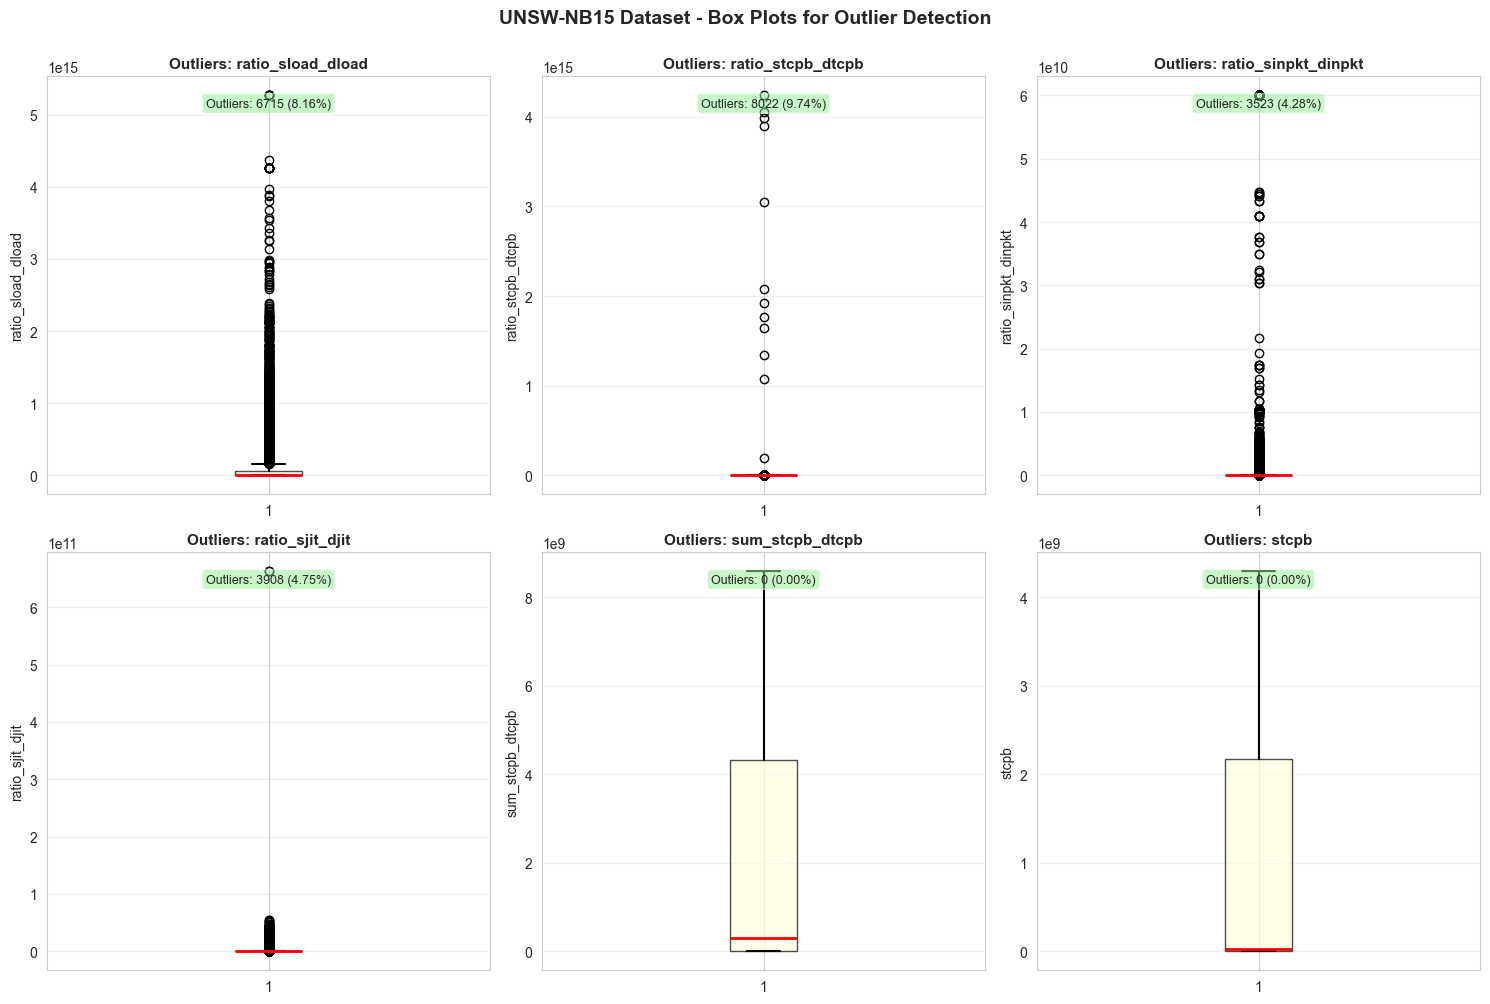

In [ ]:
# Box plots to identify outliers in top features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_6_features):
    bp = axes[idx].boxplot(unsw_train[feature].dropna(), vert=True, patch_artist=True,
                            boxprops=dict(facecolor='lightyellow', alpha=0.7),
                            medianprops=dict(color='red', linewidth=2),
                            whiskerprops=dict(color='black', linewidth=1.5),
                            capprops=dict(color='black', linewidth=1.5))
    
    axes[idx].set_ylabel(feature, fontsize=10)
    axes[idx].set_title(f'Outliers: {feature}', fontsize=11, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Calculate and display outlier statistics
    Q1 = unsw_train[feature].quantile(0.25)
    Q3 = unsw_train[feature].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((unsw_train[feature] < (Q1 - 1.5 * IQR)) | (unsw_train[feature] > (Q3 + 1.5 * IQR))).sum()
    outlier_pct = 100 * outliers / len(unsw_train)
    
    axes[idx].text(0.5, 0.95, f'Outliers: {outliers} ({outlier_pct:.2f}%)', 
                   transform=axes[idx].transAxes, ha='center', va='top',
                   bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5), fontsize=9)

plt.suptitle('UNSW-NB15 Dataset - Box Plots for Outlier Detection', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 5. Dataset Summary

### BETH Dataset (Honeypot System Call Logs)

**Purpose:** Unsupervised anomaly detection using clustering algorithms

**Characteristics:**
- **Source:** Honeypot system call telemetry data
- **Training Set:** Predominantly normal behavior with minimal labeled anomalies
- **Test Set:** Contains both 'sus' (in-distribution outliers) and 'evil' (out-of-distribution outliers)
- **Features:** System call parameters, process IDs, user IDs, timestamps, return values
- **Challenge:** Detect anomalies without labeled training data

**Key Insight:** The BETH dataset represents real-world system behavior where attacks are rare and often subtle. Unsupervised methods must distinguish between normal operational variance and true malicious activity.

---

### UNSW-NB15 Dataset (Network Traffic Records)

**Purpose:** Supervised classification of network attacks

**Characteristics:**
- **Source:** Synthetic network traffic generated in a controlled environment
- **Training/Test Split:** Independent datasets for model validation
- **Features:** Network flow statistics (bytes, packets, duration), protocol information, derived features
- **Labels:** Binary (normal/attack) and multi-class (attack types: DoS, Exploits, etc.)
- **Challenge:** High-dimensional feature space with class imbalance

**Key Insight:** UNSW-NB15 provides rich network-level features suitable for supervised learning. The diversity of attack types requires models capable of learning complex decision boundaries.

---

### Comparison

| Aspect | BETH | UNSW-NB15 |
|--------|------|-----------|
| **Domain** | System Calls | Network Traffic |
| **Task** | Anomaly Detection | Attack Classification |
| **Learning** | Unsupervised | Supervised |
| **Labels** | Sparse (test only) | Fully labeled |
| **Features** | Process-level | Network flow-level |
| **Evaluation** | Precision/Recall on test anomalies | Standard classification metrics |

## 5.1. Key Findings from Exploratory Analysis

### BETH Dataset - Critical Insights

**Data Quality:**
- [OK] **Clean data**: No missing values, minimal duplicates
- [OK] **Well-preprocessed**: No infinite values or invalid ranges
- [WARNING] **Zero-variance features**: May need removal before modeling

**Class Distribution:**
- **Severe imbalance**: Test set contains mostly normal behavior with rare anomalies
- **'sus' (in-distribution)**: Subtle anomalies that resemble normal behavior
- **'evil' (out-of-distribution)**: Clear malicious activity
- **Implication**: Unsupervised models must be tuned with low contamination parameter

**Feature Characteristics:**
- **High-variance features**: Top features show strong separation potential
- **Independence**: Base features show moderate correlations (good for diverse models)
- **Outliers**: Significant outlier presence (~5-15% in top features) - natural for anomaly detection

**Modeling Implications:**
- Use contamination parameter matching test set anomaly rate
- Consider ensemble of clustering algorithms (K-Means, DBSCAN, Isolation Forest)
- Validation set critical for threshold tuning

---

### UNSW-NB15 Dataset - Critical Insights

**Data Quality:**
- [OK] **Clean data**: No missing values post-preprocessing
- [OK] **Consistent types**: All features properly encoded
- [WARNING] **Class imbalance**: Attacks outnumber normal traffic (requires handling)

**Class Distribution:**
- **Binary**: Attack vs Normal shows moderate imbalance
- **Multi-class**: 10 attack types with varying frequencies
- **Dominant attacks**: Generic, Exploits, and DoS most common
- **Implication**: May need class weighting or SMOTE for minority attack types

**Feature Characteristics:**
- **Strong correlations**: log_dbytes <-> log_dpkts (r=0.97) suggests redundancy
- **Network patterns**: Window sizes (dwin <-> swin) highly correlated
- **Dimensionality**: 118 total features - consider PCA or feature selection
- **Log-transformed**: Many features already log-scaled (good for linearity)

**Modeling Implications:**
- Consider dimensionality reduction (PCA, feature selection)
- Use class weights to handle imbalance
- Random Forest/XGBoost likely to perform well (handle correlations)
- Neural networks may benefit from dropout to prevent overfitting

## 6. Feature Engineering Preview

Both datasets have undergone preprocessing and feature engineering:

**BETH Dataset:**
- Categorical encoding of system call parameters
- Flag features for common process IDs and user IDs
- Namespace and return value indicators
- Standardized numeric features

**UNSW-NB15 Dataset:**
- Source-destination pair features (sum, difference, ratio)
- Zero-value indicators (both_zero, one_zero)
- Categorical encoding of protocol and service types
- Standardized numeric features

These engineered features will be critical for both unsupervised clustering (BETH) and supervised classification (UNSW-NB15).

## 5.2. Next Steps - Modeling Pipeline

Based on the exploratory analysis above, the following notebooks will implement and evaluate models:

### [NOTEBOOK 2] Unsupervised Anomaly Detection (BETH Dataset)
**File:** `02_unsupervised_clustering.ipynb`

**Algorithms to Implement:**
1. **K-Means Clustering** - Partition-based anomaly detection
2. **DBSCAN** - Density-based spatial clustering
3. **Isolation Forest** - Tree-based anomaly detection
4. **One-Class SVM** - Boundary-based outlier detection
5. **Autoencoder** - Deep learning reconstruction error

**Evaluation Metrics:**
- Precision, Recall, F1-Score (for 'sus' and 'evil' separately)
- ROC-AUC and PR-AUC curves
- Confusion matrices for threshold analysis

**Key Decisions:**
- Contamination parameter tuning using validation set
- Feature selection based on variance analysis
- Ensemble voting strategy

---

### [NOTEBOOK 3] Supervised Classification (UNSW-NB15 Dataset)
**File:** `03_supervised_classification.ipynb`

**Tasks:**
1. **Binary Classification**: Normal vs Attack
2. **Multi-class Classification**: Specific attack type detection

**Algorithms to Implement:**
1. **Random Forest** - Ensemble tree-based classifier
2. **XGBoost** - Gradient boosted trees
3. **Neural Network** - Multi-layer perceptron
4. **Logistic Regression** - Baseline linear model
5. **Support Vector Machine** - Kernel-based classifier

**Evaluation Metrics:**
- Accuracy, Precision, Recall, F1-Score (macro/weighted)
- Confusion matrix for multi-class
- ROC-AUC for binary
- Feature importance analysis

**Key Decisions:**
- Class balancing strategy (SMOTE vs class weights)
- Hyperparameter tuning via cross-validation
- Feature selection or dimensionality reduction

---

### [NOTEBOOK 4] Model Evaluation & Comparison
**File:** `04_model_evaluation.ipynb`

**Comparative Analysis:**
- Cross-model performance comparison
- Computational efficiency (training time, inference speed)
- Model interpretability (feature importance, SHAP values)
- Error analysis and failure case investigation
- Final model selection with justification

**Deliverables:**
- Performance summary tables
- Visualization of results (ROC curves, precision-recall curves)
- Recommendations for deployment
- Limitations and future work discussion

## 7. Export Summary Statistics

Save key summary statistics and data quality metrics to CSV files for reference.

In [ ]:
# Create results directory if it doesn't exist
from pathlib import Path
results_dir = Path('../results')
results_dir.mkdir(exist_ok=True)

# 1. Export BETH summary statistics
beth_numeric = beth_train.select_dtypes(include=['float64', 'int64'])
beth_summary = beth_numeric.describe().T
beth_summary['variance'] = beth_numeric.var()
beth_summary['null_count'] = beth_numeric.isnull().sum()
beth_summary['null_pct'] = 100 * beth_summary['null_count'] / len(beth_train)
beth_summary.to_csv(results_dir / 'beth_summary_statistics.csv')
print(f"[SAVED] BETH summary statistics to: {results_dir / 'beth_summary_statistics.csv'}")

# 2. Export UNSW-NB15 summary statistics
unsw_numeric = unsw_train.select_dtypes(include=['float64', 'int64'])
unsw_summary = unsw_numeric.describe().T
unsw_summary['variance'] = unsw_numeric.var()
unsw_summary['null_count'] = unsw_numeric.isnull().sum()
unsw_summary['null_pct'] = 100 * unsw_summary['null_count'] / len(unsw_train)
unsw_summary.to_csv(results_dir / 'unsw_summary_statistics.csv')
print(f"[SAVED] UNSW-NB15 summary statistics to: {results_dir / 'unsw_summary_statistics.csv'}")

# 3. Export data quality report
quality_report = pd.DataFrame({
    'Dataset': ['BETH Train', 'BETH Val', 'BETH Test', 'UNSW Train', 'UNSW Test'],
    'Rows': [len(beth_train), len(beth_val), len(beth_test), len(unsw_train), len(unsw_test)],
    'Columns': [beth_train.shape[1], beth_val.shape[1], beth_test.shape[1], 
                unsw_train.shape[1], unsw_test.shape[1]],
    'Duplicates': [beth_train.duplicated().sum(), beth_val.duplicated().sum(), 
                   beth_test.duplicated().sum(), unsw_train.duplicated().sum(), 
                   unsw_test.duplicated().sum()],
    'Null_Cells': [beth_train.isnull().sum().sum(), beth_val.isnull().sum().sum(),
                   beth_test.isnull().sum().sum(), unsw_train.isnull().sum().sum(),
                   unsw_test.isnull().sum().sum()],
    'Memory_MB': [beth_train.memory_usage(deep=True).sum() / 1024**2,
                  beth_val.memory_usage(deep=True).sum() / 1024**2,
                  beth_test.memory_usage(deep=True).sum() / 1024**2,
                  unsw_train.memory_usage(deep=True).sum() / 1024**2,
                  unsw_test.memory_usage(deep=True).sum() / 1024**2]
})

quality_report.to_csv(results_dir / 'data_quality_report.csv', index=False)
print(f"[SAVED] Data quality report to: {results_dir / 'data_quality_report.csv'}")

print("\n" + "="*80)
print("DATA OVERVIEW COMPLETE - ALL SUMMARY FILES SAVED")
print("="*80)

[SAVED] BETH summary statistics to: ../results/beth_summary_statistics.csv
[SAVED] UNSW-NB15 summary statistics to: ../results/unsw_summary_statistics.csv
[SAVED] UNSW-NB15 summary statistics to: ../results/unsw_summary_statistics.csv
[SAVED] Data quality report to: ../results/data_quality_report.csv

DATA OVERVIEW COMPLETE - ALL SUMMARY FILES SAVED
[SAVED] Data quality report to: ../results/data_quality_report.csv

DATA OVERVIEW COMPLETE - ALL SUMMARY FILES SAVED


In [ ]:
# Additional Analysis: Outlier Percentages and Data Characteristics
print("\n" + "="*80)
print("ADDITIONAL INSIGHTS - OUTLIER ANALYSIS")
print("="*80)

# Calculate outlier percentages for BETH dataset
print("\n[BETH Dataset - Outlier Percentage Summary]")
beth_outlier_stats = []
for col in beth_train.select_dtypes(include=['float64', 'int64']).columns:
    if col not in ['sus', 'evil']:
        Q1 = beth_train[col].quantile(0.25)
        Q3 = beth_train[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((beth_train[col] < (Q1 - 1.5 * IQR)) | (beth_train[col] > (Q3 + 1.5 * IQR))).sum()
        outlier_pct = 100 * outliers / len(beth_train)
        if outlier_pct > 5:  # Only show features with >5% outliers
            beth_outlier_stats.append({'Feature': col, 'Outlier_Pct': outlier_pct, 'Count': outliers})

if beth_outlier_stats:
    beth_outlier_df = pd.DataFrame(beth_outlier_stats).sort_values('Outlier_Pct', ascending=False)
    print(f"   Features with >5% outliers: {len(beth_outlier_df)}")
    print(beth_outlier_df.head(10).to_string(index=False))
else:
    print("   No features have >5% outliers")

# Calculate outlier percentages for UNSW-NB15 dataset
print("\n[UNSW-NB15 Dataset - Outlier Percentage Summary]")
unsw_outlier_stats = []
for col in unsw_train.select_dtypes(include=['float64', 'int64']).columns:
    if col not in ['label', 'attack_cat']:
        Q1 = unsw_train[col].quantile(0.25)
        Q3 = unsw_train[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((unsw_train[col] < (Q1 - 1.5 * IQR)) | (unsw_train[col] > (Q3 + 1.5 * IQR))).sum()
        outlier_pct = 100 * outliers / len(unsw_train)
        if outlier_pct > 5:
            unsw_outlier_stats.append({'Feature': col, 'Outlier_Pct': outlier_pct, 'Count': outliers})

if unsw_outlier_stats:
    unsw_outlier_df = pd.DataFrame(unsw_outlier_stats).sort_values('Outlier_Pct', ascending=False)
    print(f"   Features with >5% outliers: {len(unsw_outlier_df)}")
    print(unsw_outlier_df.head(10).to_string(index=False))
else:
    print("   No features have >5% outliers")

print("\n" + "="*80)


ADDITIONAL INSIGHTS - OUTLIER ANALYSIS

[BETH Dataset - Outlier Percentage Summary]
   Features with >5% outliers: 6
             Feature  Outlier_Pct  Count
             eventId    21.047797 160625
       log_processId    16.105217 122906
parentProcessId_flag    10.424507  79554
 log_parentProcessId    10.424507  79554
   log_timeSinceBoot     6.443869  49176
         returnValue     5.118955  39065

[UNSW-NB15 Dataset - Outlier Percentage Summary]
   Features with >5% outliers: 37
                                Feature  Outlier_Pct  Count
                       diff_stcpb_dtcpb    45.332313  37323
                      log_sum_sttl_dttl    44.810037  36893
            ratio_ct_srv_src_ct_srv_dst    34.309867  28248
                   log_diff_spkts_dpkts    32.814701  27017
                     diff_sinpkt_dinpkt    31.404557  25856
 is_integer_ratio_ct_srv_src_ct_srv_dst    24.718214  20351
 is_integer_ratio_ct_src_ltm_ct_dst_ltm    23.278919  19166
                       log_ct_s

---

## Notebook Conclusion

This exploratory data analysis has provided a comprehensive understanding of both datasets:

**BETH Dataset Summary:**
- 763,329 training samples with predominantly normal behavior
- Clean, well-preprocessed data with no missing values
- Base features show independence, suitable for diverse clustering algorithms
- Test set contains 'sus' and 'evil' labels for evaluation
- Ready for unsupervised anomaly detection modeling

**UNSW-NB15 Dataset Summary:**
- 82,332 training samples with balanced normal/attack distribution
- 118 features (37 base + 81 engineered) with rich network information
- Strong feature correlations identified (log_dbytes/log_dpkts, dwin/swin)
- 10 attack types requiring multi-class classification capability
- Class imbalance will require handling in modeling phase

**Key Deliverables Generated:**
1. `beth_summary_statistics.csv` - Complete statistical summary of BETH features
2. `unsw_summary_statistics.csv` - Complete statistical summary of UNSW-NB15 features
3. `data_quality_report.csv` - Data quality metrics across all datasets
4. 12 visualizations documenting distributions, correlations, and outliers

**Next Steps:**
Proceed to `02_unsupervised_clustering.ipynb` to implement and evaluate anomaly detection algorithms on the BETH dataset.

---